In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

C:\Users\snuist\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 파라미터 세팅

In [2]:
sess = tf.Session()

embedding_size = 50
vocabulary_size = 2000
batch_size = 100
max_words = 100

In [3]:
# Declare stop words
stops = stopwords.words('english')

# Load Data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
print('Done.')

Loading Data
Normalizing Text Data
Done.


## 훈련 데이터, 테스트 데이터로 나누기

In [4]:
'''
np.random.choice(a, b, replace=False)
a: integer -> np.arange(a) 이런 식으로 함수에서 쓰임
b: 뽑는 갯수
replace=False: 비복원추출
'''
train_indices = np.random.choice(len(target), round(0.8*len(target)), replace=False)
test_indices = np.array(list(set(range(len(target))) - set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

## 딕셔너리 불러오기

In [5]:
dict_file = os.path.join('..','Tensorflow cookbook','temp','movie_vocab.pkl')
word_dictionary = pickle.load(open(dict_file, 'rb'))

# Convert texts into lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
# 14번 코드 설명
# 일단 어떤 문장이든 padding을 해놓고 max_words로 끊어내는 방식을 취하고 있다.
# 예) let max_words = 5, then "You are dumbass." -> [14, 3, 5] 
# -> [14, 3, 5, 0, 0, 0, 0, 0] -> max_words가 5개 이므로 [14, 3, 5, 0, 0] 으로 끊어짐
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

## 모델 만들기

In [6]:
print("Creating Model")
# Define embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Define model:
# Creat variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
# x_data_dimension :    (total_number_of_sentence, max_words)
x_data = tf.placeholder(shape=[None, max_words], dtype=tf.int32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Lookup embedding vectors
# embed_dimension :    (total_number_of_sentence, max_words, embedding_size)
embed = tf.nn.embedding_lookup(embeddings, x_data)
# Take aveage of all word embeddings in documents
# embed_avg_dimension: (total_number_of_sentence, embedding_size) 
# 본래 디폴트로 keepdims = False 이므로 원래 total_number_of_sentence, 1, embedding_size
# 인데 중간 dimension이 사라져서 (total_number_of_sentence, embedding_size)임
embed_avg = tf.reduce_mean(embed, 1)

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(embed_avg, A), b)

print("Done")

Creating Model
Done


In [7]:
# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
my_opt = tf.train.AdagradOptimizer(0.005)
train_step = my_opt.minimize(loss)

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Load model embeddings
model_checkpoint_path = os.path.join('..','Tensorflow cookbook',
                                    'temp','cbow_movie_embeddings.ckpt')
saver = tf.train.Saver({"embeddings": embeddings})
saver.restore(sess, model_checkpoint_path)

INFO:tensorflow:Restoring parameters from ..\Tensorflow cookbook\temp\cbow_movie_embeddings.ckpt


In [8]:
#This code is used to close local sessions in this kernel during experiments:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [11]:
# Start Logistic Regression
print("Starting Model Training")
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    # np.arange(text_data_train.shape[0])에서 랜덤하게 batch_size만큼 뽑아 rand_index만듦
    rand_index = np.random.choice(text_data_train.shape[0], size=batch_size)
    rand_x = text_data_train[rand_index]
    rand_y = np.transpose([target_train[rand_index]])
    train_dict = {x_data: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100 == 0:
        i_data.append(i+1)
        
        # Train/Test loss
        train_loss_temp = sess.run(loss, feed_dict=train_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, 
                                  feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        # Train/Test accuracy
        train_acc_temp = sess.run(accuracy, feed_dict=train_dict)
        train_acc.append(train_acc_temp)
        
        test_acc_temp = sess.run(accuracy, 
                                 feed_dict={x_data: text_data_test, y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500 == 0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generations # {}. Train Loss (Test Loss): {:2f} ({:2f}). Train Acc (Test Acc): {:2f} ({:2f})'.format(*acc_and_loss))

Starting Model Training
Generations # 500. Train Loss (Test Loss): 0.700000 (0.690000). Train Acc (Test Acc): 0.470000 (0.510000)
Generations # 1000. Train Loss (Test Loss): 0.700000 (0.690000). Train Acc (Test Acc): 0.410000 (0.500000)
Generations # 1500. Train Loss (Test Loss): 0.700000 (0.690000). Train Acc (Test Acc): 0.440000 (0.500000)
Generations # 2000. Train Loss (Test Loss): 0.690000 (0.690000). Train Acc (Test Acc): 0.620000 (0.510000)
Generations # 2500. Train Loss (Test Loss): 0.690000 (0.690000). Train Acc (Test Acc): 0.510000 (0.500000)
Generations # 3000. Train Loss (Test Loss): 0.690000 (0.690000). Train Acc (Test Acc): 0.490000 (0.510000)
Generations # 3500. Train Loss (Test Loss): 0.700000 (0.690000). Train Acc (Test Acc): 0.470000 (0.500000)
Generations # 4000. Train Loss (Test Loss): 0.690000 (0.690000). Train Acc (Test Acc): 0.520000 (0.500000)
Generations # 4500. Train Loss (Test Loss): 0.700000 (0.690000). Train Acc (Test Acc): 0.390000 (0.510000)
Generations # 

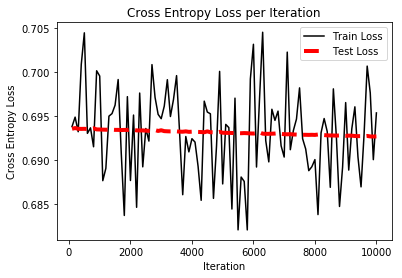

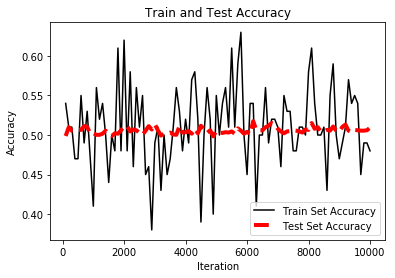

In [13]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()